In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray
from astropy.time import Time
import astropy.io
import pymap3d
import datetime

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Digital elevation model (DEM) available [here](http://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/sldem2015/tiles/float_img/).

In [2]:
n_lat, n_lon = 15360, 23040
lat_min, lat_max = 0.0, 30.0
lon_min, lon_max = 135.0, 180.0
dem_data = np.flipud(np.memmap('sldem2015_512_00n_30n_135_180_float.img', dtype='float32').reshape(n_lat, n_lon))
dem_full = xarray.DataArray(dem_data,
                           coords = [np.linspace(lat_min, lat_max, n_lat, endpoint = False),
                                     np.linspace(lon_min, lon_max, n_lon, endpoint = False)],
                           dims = ['lat', 'lon'])
lon_crop_min = 156
lon_crop_max = 162
lat_crop_min = 15
lat_crop_max = 18
dem_extent = [lon_crop_min, lon_crop_max, lat_crop_min, lat_crop_max]
dem = dem_full.sel(lon = slice(lon_crop_min,lon_crop_max), lat = slice(lat_crop_min,lat_crop_max))

PA to ME lunar axes rotation. Taken from [DE421 Lunar Orbit, Physical Librations, and Surface Coordinates](ftp://ssd.jpl.nasa.gov/pub/eph/planets/ioms/de421_moon_coord_iom.pdf).

In [3]:
sec_to_rad = 2 * np.pi / 360 / 3600
p2 = 0.30 * sec_to_rad
p1 = -78.56 * sec_to_rad
tau = 67.92 * sec_to_rad
PA_to_ME = np.array([[1,0,0],[0,np.cos(-p2),-np.sin(-p2)],[0,np.sin(-p2),np.cos(-p2)]]) @ \
    np.array([[np.cos(p1), 0, np.sin(p1)], [0, 1, 0], [-np.sin(p1), 0, np.cos(p1)]]) @ \
    np.array([[np.cos(-tau), -np.sin(-tau), 0], [np.sin(-tau), np.cos(-tau), 0], [0, 0, 1]])

In [4]:
mjd_unixtimestamp_offset = 10587.5
seconds_in_day = 3600 * 24

def mjd2unixtimestamp(m):
    return (m - mjd_unixtimestamp_offset) * seconds_in_day

def load_gmat_track(path):
    lunar_radius = 1737.4
    
    gmat_data = np.fromfile(path, sep = ' ').reshape((-1,4))
    
    # Read PA coordinates and rotate to MA axis
    xyz_PA = gmat_data[:,1:]
    xyz_ME = np.einsum('ij,kj->ki', PA_to_ME, xyz_PA)
    
    # Compute time in datetime format
    time = Time(mjd2unixtimestamp(gmat_data[:,0]), format = 'unix').datetime
    
    latitude = np.rad2deg(np.arctan2(xyz_ME[:,2], np.sqrt(np.sum(xyz_ME[:,:2]**2, axis = 1))))
    longitude = np.rad2deg(np.arctan2(xyz_ME[:,1], xyz_ME[:,0]))
    altitude = np.sqrt(np.sum(xyz_PA**2, axis = 1)) - lunar_radius
    
    sel = np.where(np.abs(altitude) < 10)
    
    return xarray.DataArray(altitude[sel],
                             coords = {'time' :  time[sel],
                                       'lat' : ('time', latitude[sel]),
                                       'lon' : ('time', longitude[sel])},
                             dims = ['time'])

def load_csv_track(path, altitude_correction = 0):
    csv = astropy.io.ascii.read(path)
    
    # Compute time in datetime format
    time = np.array([np.datetime64(datetime.datetime.strptime(t.replace('.000', ''), '%d %b %Y %H:%M:%S').isoformat()) for t in csv['Time (UTCG)']])
    
    latitude = csv['Lat (deg)']
    longitude = csv['Lon (deg)']
    altitude = csv['Alt (km)'] + altitude_correction
    
    sel = np.where(np.abs(altitude) < 10)
    
    return xarray.DataArray(altitude[sel],
                             coords = {'time' :  time[sel],
                                       'lat' : ('time', latitude[sel]),
                                       'lon' : ('time', longitude[sel])},
                             dims = ['time'])

In [5]:
reference_lla = [16.6858, 159.5218, -1561.12]
moon_ellipsoid = pymap3d.Ellipsoid(model = 'moon')

def track_comparison(track1, track2):
    plt.figure(figsize = (12,12), facecolor = 'w')
    plt.imshow(dem, extent = dem_extent, origin = 'bottom', cmap = 'gray')
    plt.plot(track1.coords['lon'], track1.coords['lat'], 'C0')
    plt.plot(track2.coords['lon'], track2.coords['lat'], 'C1')
    plt.title('Tracks over lunar surface')
    plt.xlabel('Longitude (deg)')
    plt.ylabel('Latitude (deg)')
    
    plt.figure(figsize = (12,6), facecolor = 'w')
    track1.coords['lat'].plot()
    track2.coords['lat'].plot()
    plt.title('Track comparison')
    plt.xlabel('Latitude (deg)')
    plt.ylabel('Time')
    
    plt.figure(figsize = (12,6), facecolor = 'w')
    track1.coords['lon'].plot()
    track2.coords['lon'].plot()
    plt.title('Track comparison')
    plt.xlabel('Longitude (deg)')
    plt.ylabel('Time')
    
    plt.figure(figsize = (12,6), facecolor = 'w')
    track1.plot()
    track2.plot()
    plt.title('Track comparison')
    plt.xlabel('Altitude (km)')
    plt.ylabel('Time')

def track_analysis(track):
    # upsample track to 100ms sampling
    upsample_time = track.coords['time'][0].values + np.arange(0,(track.coords['time'][-1] - track.coords['time'][0]), 100000000)
    track = track.interp(time = upsample_time)
    
    dem_below_track = dem.interp(lat = track.coords['lat'], lon = track.coords['lon'])
    clearence = track - dem_below_track
    
    m = np.argmin(np.abs(clearence))
    if clearence[m] > 0:
        a = m
        b = m+1
    else:
        a = m-1
        b = m
    zero_clearence = clearence.coords['time'][a] \
        - clearence[a] * (clearence.coords['time'][b]-clearence.coords['time'][a]) / (clearence[b] - clearence[a])

    impact_point = clearence.interp(time = zero_clearence)
    impact_lat = impact_point.coords['lat'].values
    impact_lon = impact_point.coords['lon'].values
    impact_alt = 1e3*track.interp(time = impact_point.coords['time']).values
    print('IMPACT POINT: Time = {}, Latitude = {:.4f}, Longitude = {:.4f}, Altitude = {:.2f}'.format(
                                                            impact_point.coords['time'].values,
                                                            impact_lat,
                                                            impact_lon,
                                                            impact_alt))
    impact_enu = pymap3d.geodetic2enu(impact_lat, impact_lon, impact_alt,
                                      reference_lla[0], reference_lla[1], reference_lla[2],
                                      ell = moon_ellipsoid)
    print('With respect to reference: East = {:.1f} m, North = {:.1f} m , Up = {:.1f} m'.format(*impact_enu))
    
    track_before_impact = track.sel(time = slice(track.coords['time'][0], impact_point.coords['time']))
    track_after_impact = track.sel(time = slice(impact_point.coords['time'], track.coords['time'][-1]))
    
    plt.figure(figsize = (12,12), facecolor = 'w')
    plt.imshow(dem, extent = dem_extent, origin = 'bottom', cmap = 'gray')
    plt.plot(track_before_impact.coords['lon'], track_before_impact.coords['lat'], 'C1')
    plt.plot(track_after_impact.coords['lon'], track_after_impact.coords['lat'], 'C1--')
    plt.plot(impact_point.coords['lon'], impact_point.coords['lat'], 'C1o')
    plt.title('Track over lunar surface')
    plt.xlabel('Longitude (deg)')
    plt.ylabel('Latitude (deg)')
    
    plt.figure(figsize = (12,6), facecolor = 'w')
    track.plot(color = 'C1', label = 'DSLWP-B')
    dem_below_track.plot(color = 'grey', label = 'Lunar surface')
    plt.xlabel('Time')
    plt.ylabel('Altitude (km)')
    plt.title('Altitude profile')
    plt.legend()
    
    plt.figure(figsize = (12,6), facecolor = 'w')
    clearence.plot(color = 'C1')
    plt.axhline(0, color = 'grey')
    plt.ylim((-3,3))
    plt.grid()
    plt.xlabel('Time')
    plt.ylabel('Distance (km)')
    plt.title('Clearence above lunar surface')

The tracking files used below are generated with GMAT and `crash.script`.

IMPACT POINT: Time = 2019-07-31T14:20:03.310932000, Latitude = 16.6858, Longitude = 159.5218, Altitude = -1561.12
With respect to reference: East = -0.4 m, North = 0.5 m , Up = 0.0 m


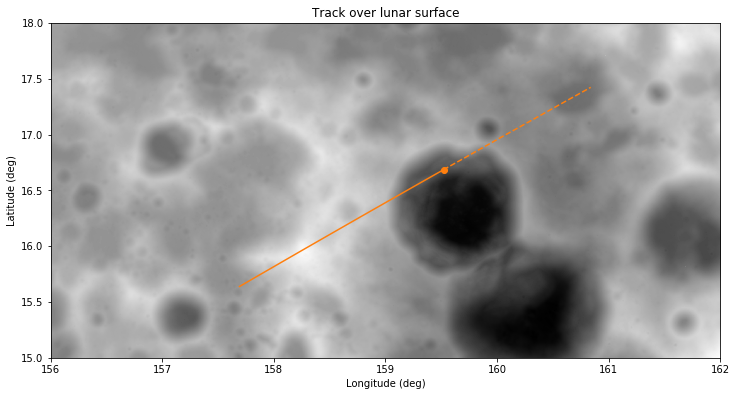

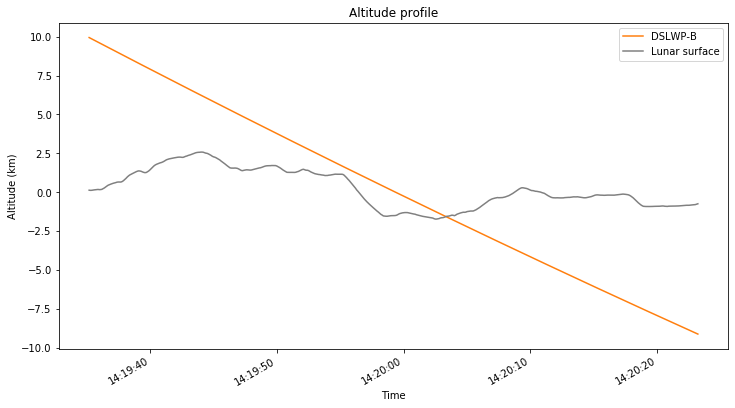

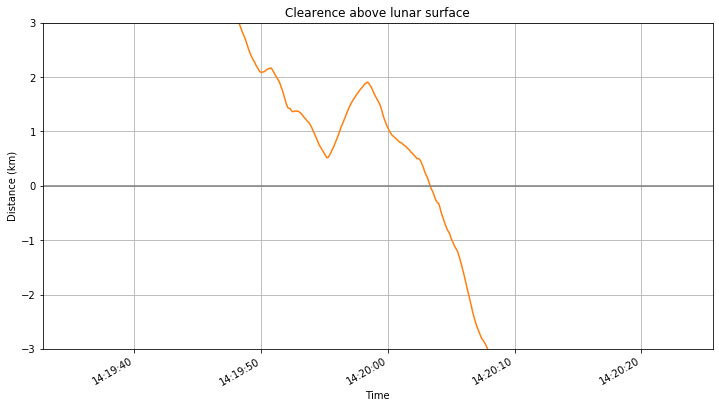

In [6]:
# Luna centred ICRF ephemeris from 2019-07-25
track_analysis(load_gmat_track('dslwp_luna_pos_25jul.txt'))

IMPACT POINT: Time = 2019-07-31T14:19:54.004249000, Latitude = 16.6785, Longitude = 159.5196, Altitude = -1654.19
With respect to reference: East = -64.6 m, North = -221.6 m , Up = -93.1 m


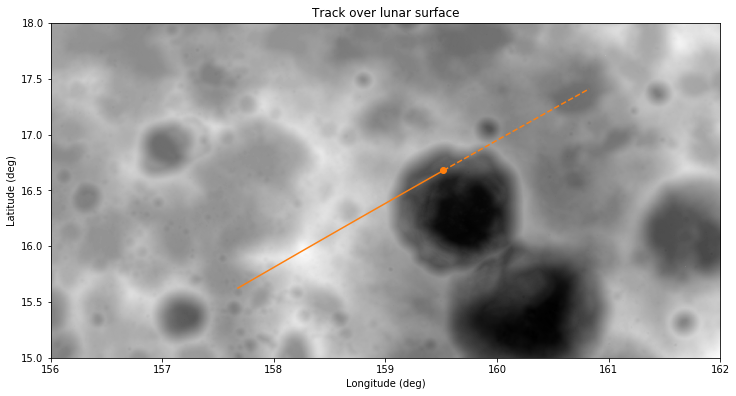

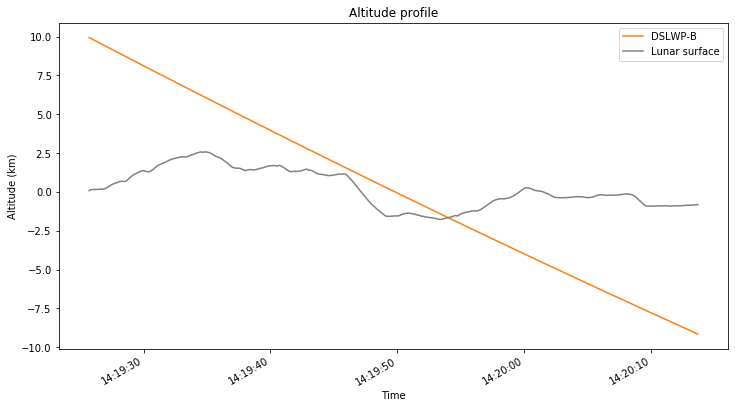

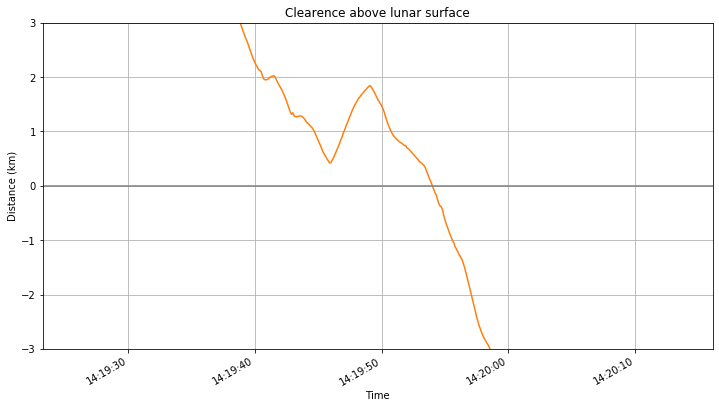

In [7]:
# Luna centred ICRF ephemeris from 2019-07-18
track_analysis(load_gmat_track('dslwp_luna_pos_18jul.txt'))

IMPACT POINT: Time = 2019-07-31T14:18:43.744813000, Latitude = 16.6834, Longitude = 159.5387, Altitude = -1647.23
With respect to reference: East = 490.5 m, North = -72.6 m , Up = -86.2 m


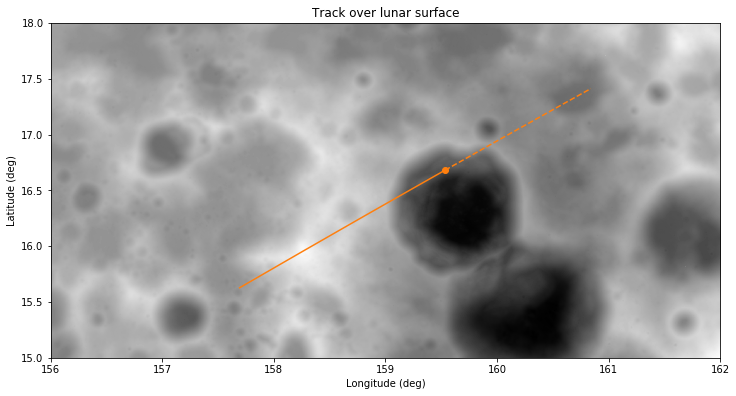

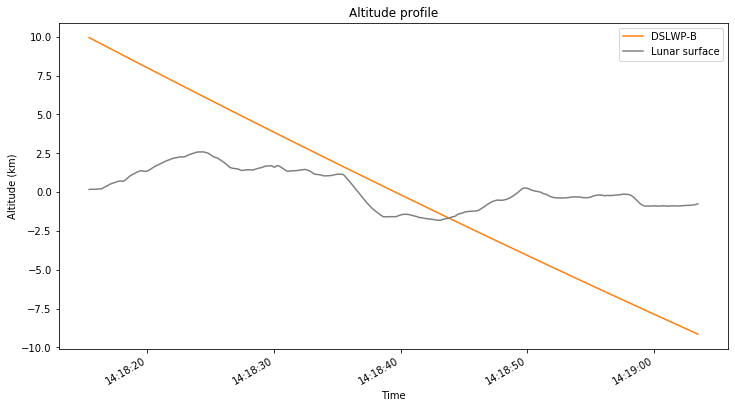

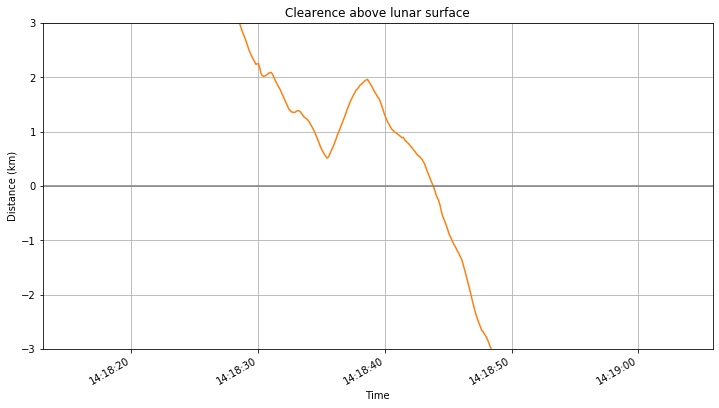

In [8]:
# Luna centred ICRF ephemeris from 2019-06-28
track_analysis(load_gmat_track('dslwp_luna_pos_28jun.txt'))

Impact location obtained by Cees Bassa with CSV file [here](https://github.com/cbassa/dslwp_analysis/blob/master/dslwp_impact.ipynb)

In [9]:
pymap3d.geodetic2enu(16.675, 159.617, 0, reference_lla[0], reference_lla[1], reference_lla[2], ell = moon_ellipsoid)

(2766.3410883251972, -326.94541006886107, 1558.8876808685357)

IMPACT POINT: Time = 2019-07-31T14:20:15.400000000, Latitude = 16.6755, Longitude = 159.6166, Altitude = -1874.87
With respect to reference: East = 2752.9 m, North = -311.6 m , Up = -316.0 m


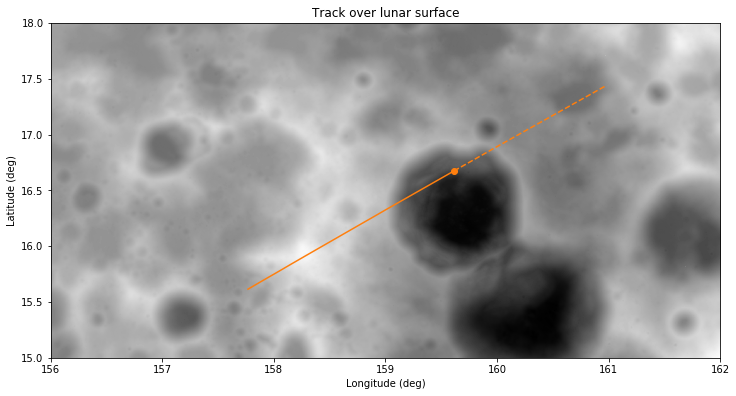

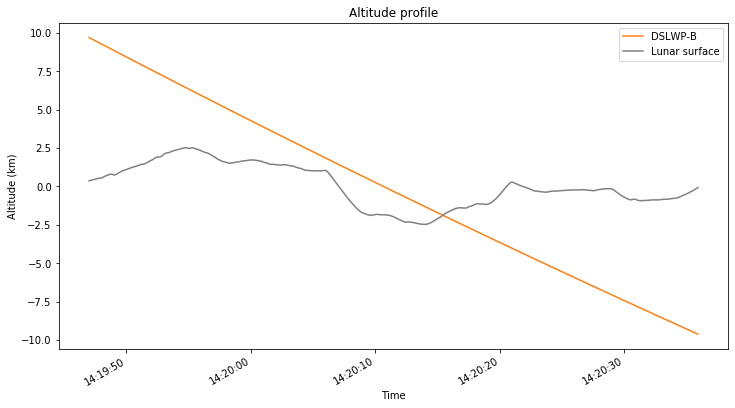

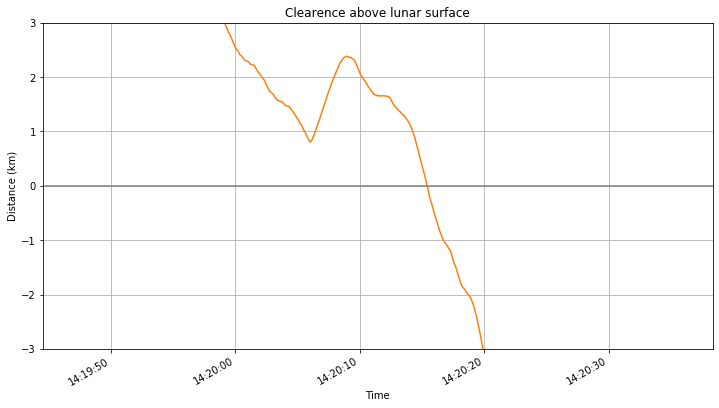

In [10]:
# CSV file computed by Wei Mingchuan BG2BHC
track_analysis(load_csv_track('DSLWP-B1-MOON LLA Position.csv'))

Comparison between track obtained in GMAT and Wei's track. For some reason it seems that Wei's track is displaced to the southeast.

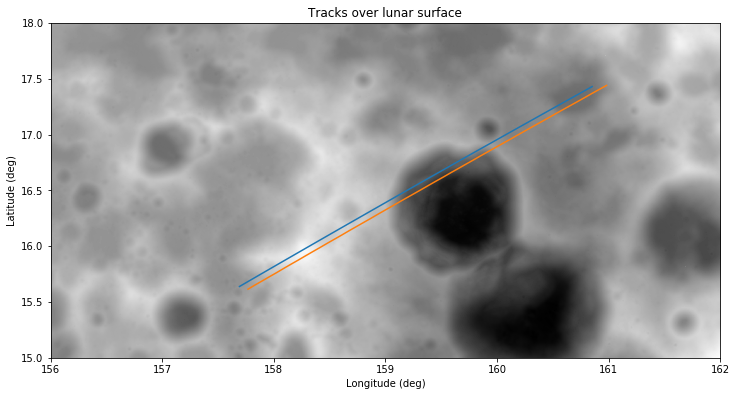

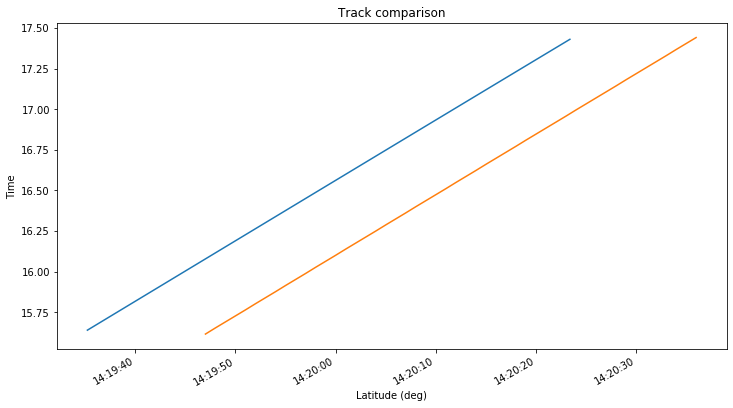

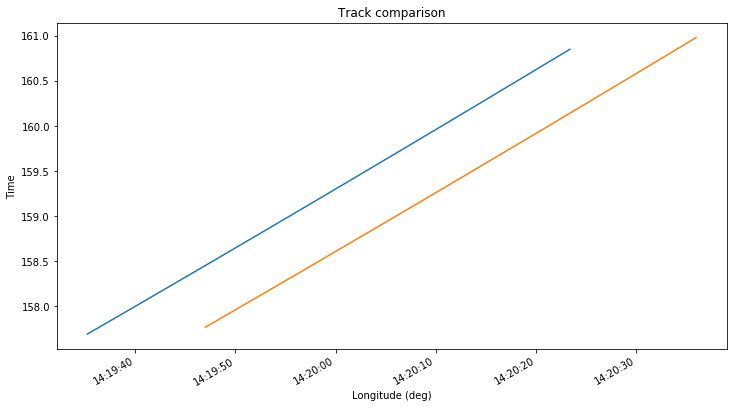

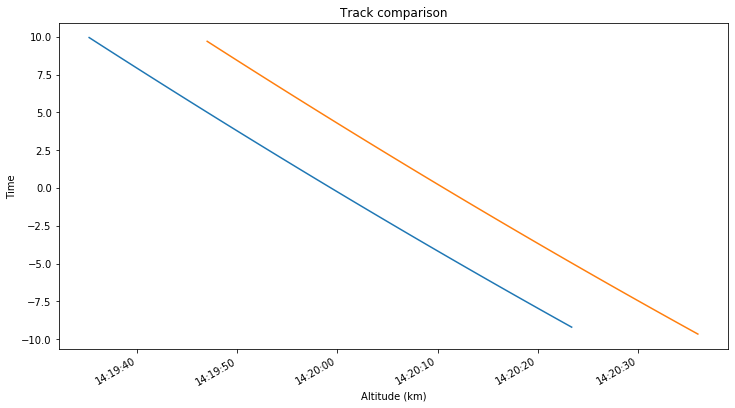

In [11]:
track_comparison(load_gmat_track('dslwp_luna_pos_25jul.txt'), load_csv_track('DSLWP-B1-MOON LLA Position.csv'))